# Astra target landing site example

In [1]:
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d

%matplotlib notebook

In [2]:
targetLat = 28.33
targetLon = -79.8
targetElev = 0.

simulator = targetFlight(start_dateTime=datetime.now()+timedelta(days=1),
                 targetLat=targetLat,
                 targetLon=targetLon,
                 launchSites=[(29.2108, -81.0228, 4.)],
                 balloonGasType='Helium',
                 balloonModel='TA100',
                 nozzleLift=1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=24,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 trainEquivSphereDiam=0.1,
                 floatingFlight=False,
                 floatingAltitude=None,
                 ventingStart=1000,
                 excessPressureCoeff=1.,
                 outputFile='',
                 debugging=False,
                 log_to_file=False,
                 progress_to_file=False)

best_result, distances_map = simulator.bruteForce()

DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_12z.ascii?hgtprs[9:18][0:46][227:249][511:605] HTTP/1.1" 200 485


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_12z.ascii?tmpprs[9:18][0:46][227:249][511:605] HTTP/1.1" 200 485


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_12z.ascii?vgrdprs[9:18][0:46][227:249][511:605] HTTP/1.1" 200 486


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_12z.ascii?ugrdprs[9:18][0:46][227:249][511:605] HTTP/1.1" 200 486


Weather downloaded.

DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_06z.ascii?tmpprs[11:20][0:46][227:249][511:605] HTTP/1.1" 200 None


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_06z.ascii?ugrdprs[11:20][0:46][227:249][511:605] HTTP/1.1" 200 None


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_06z.ascii?hgtprs[11:20][0:46][227:249][511:605] HTTP/1.1" 200 None


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170524/gfs_0p50_06z.ascii?vgrdprs[11:20][0:46][227:249][511:605] HTTP/1.1" 200 None


Weather downloaded.
2017-05-25 13:33:38.651461


<IPython.core.display.Javascript object>


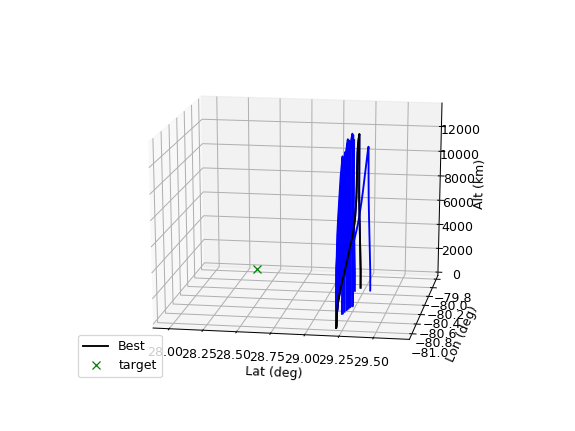

<IPython.core.display.Javascript object>


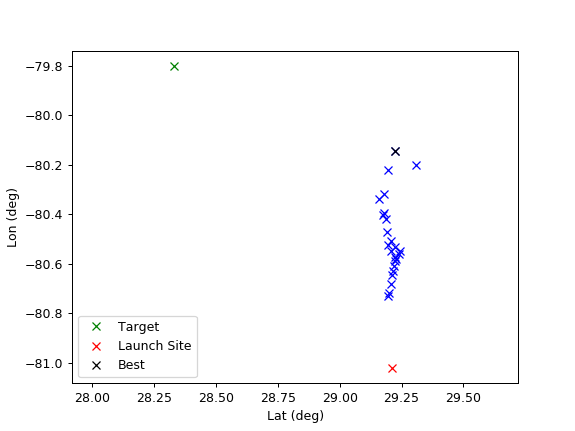

In [11]:
# %load_ext autoreload
%autoreload

fig1, ax1 = simulator.plotPaths3D()

fig2, ax2 = simulator.plotLandingSites()

# add the point obtained by scipy:
best = simulator.optimizeTargetLandingSite(method='Nelder-Mead' x0=0.5)



In [58]:
lst = [np.linspace(0, 1, 101), np.linspace(1, 2, 101), np.linspace(2, 3, 101)]

np.transpose(lst)[-1][0]

1.0

<IPython.core.display.Javascript object>


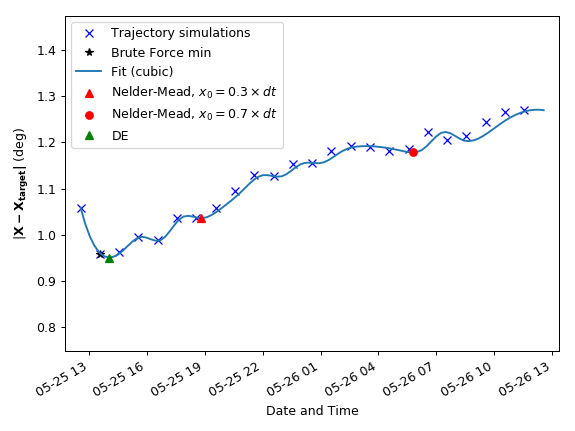

In [49]:

fig = plt.figure()
ax = fig.add_subplot(111)


plt.axis('equal')
dateTimes = []
distances = []
for result_dict in simulator.results:
    result = result_dict['result']
    dateTime = result_dict['launchDateTime']
    dateTimes.append(dateTime)
    distance = distances_map[dateTime]
    distances.append(distance)

ax.plot(dateTimes, distances, 'bx', label='Trajectory simulations')
ax.plot(best_result['launchDateTime'], distances_map[best_result['launchDateTime']], 'k*', label='Brute Force min')

import matplotlib.dates as mdates

xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
fig.autofmt_xdate()

ax.set_xlabel('Date and Time')
ax.set_ylabel(r'$|\bf{X} - \bf{X_{target}}|$ (deg)')

In [51]:
# test the scipy algorithms:

datetimeVector =  np.linspace(0, simulator.windowDuration, len(distances_map.keys())) 
distanceVector = list(distances_map.values())

f_curve = interp1d(datetimeVector, distanceVector, kind='cubic')

new_timedelta_vector = np.linspace(0, simulator.windowDuration, 100)
newdistances = f_curve(new_timedelta_vector)
new_datetime_vector = [simulator.start_dateTime + timedelta(hours=h) for h in new_timedelta_vector]

ax.plot(new_datetime_vector, newdistances, label='Fit (cubic)')

In [52]:
import scipy.optimize

res = scipy.optimize.minimize(f_curve, x0=[0.3*simulator.windowDuration], method='BFGS',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, '^r', label=r'Nelder-Mead, $x_0=0.3 \times dt$')

res = scipy.optimize.minimize(f_curve, x0=[0.7*simulator.windowDuration], method='BFGS',
#                               bounds=[(0.1, simulator.windowDuration-0.1)],
                             options={"disp": True})
best_time_model = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_model, res.fun, 'or', label=r'Nelder-Mead, $x_0=0.7 \times dt$')

Optimization terminated successfully.
         Current function value: 1.035923
         Iterations: 7
         Function evaluations: 30
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.177777
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 8


In [53]:
help(scipy.optimize.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        Objective function.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (Jacobian, Hessian).
    method : str or callable, op

In [54]:
import scipy.optimize

res = scipy.optimize.differential_evolution(f_curve,
                              bounds=[(0.1, simulator.windowDuration-0.1)],
                              polish=False)
best_time_de = simulator.start_dateTime + timedelta(hours=res.x[0])
# res.fun
ax.plot(best_time_de, res.fun, '^g', label='DE')
print(res.nit)
lgd = ax.legend(loc='upper left')
ax.set_facecolor("white")
plt.tight_layout()
fig.savefig('brute_force_comparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


4


## Testing

In [ ]:
 datetimeVector = [self.start_dateTime + timedelta(hours=t)
                            for t in range(self.windowDuration)]

nozzleLiftLowerBound = 0.4
nozzleLiftUpperBound = 1.0
nozzelLift_Vector = np.linspace(nozzleLiftLowerBound, nozzleLiftUpperBound)
self.results = {}

distance_map = {}
for i, launchSiteForecast in enumerate(self.launchSiteForecasts):
    self.environment = launchSiteForecast

    for j, t in enumerate(datetimeVector):
        distance_lift_vec = np.zeros(np.length(nozzelLift_Vector))
        for k, L in enumerate(nozzelLift_Vector):
            # brute force approach
            distance = self.targetDistance(t)
            distance_lift_vec[k] = distance

        distance_map[t] = distance_Vector  

In [ ]:
# ascent rate penalty function
